# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt 
import random
import re
import os
import time
import zipfile
from IPython.display import HTML, display

# CPU optimizations

In [4]:
if not torch.cuda.is_available():
    print("Default Configurations:")
    print("Intra-op threads:", torch.get_num_threads())
    print("Inter-op threads:", torch.get_num_interop_threads())
    print()
    print("Updated Configurations:")
    cpu_threads =  os.cpu_count()
    cpu_threads = int(cpu_threads * 0.8) # using 80% of the logical threads
    torch.set_num_threads(cpu_threads)
    torch.set_num_interop_threads(min(8, cpu_threads))
    
    os.environ["OMP_NUM_THREADS"] = str(cpu_threads)
    os.environ["MKL_NUM_THREADS"] = str(cpu_threads)
    os.environ["OPENBLAS_NUM_THREADS"] = str(cpu_threads)
    os.environ["NUMEXPR_NUM_THREADS"] = str(cpu_threads)
    
    print(f"Using {cpu_threads} threads for PyTorch operations.")
    print(f"Intra-op threads={torch.get_num_threads()}")
    print(f"Inter-op threads={torch.get_num_interop_threads()}")

# Configuration Settings for Dataset, Model, and Training Environment

In [5]:
location = "stanfordnlp/imdb"

pin_memory = False # enable if you have GPU
if torch.cuda.is_available():
    num_workers = 2
    print("yes")
else:
    num_workers = 8

batch_size = 64

load_pre_trained_model = False # enable only if the pretrained models are available
saved_dir = ""
save_model = True

bert_model = "prajjwal1/bert-mini"

yes


# Implementation Approach
Implementing 16 separate classes for each model variant is highly inefficient. Instead, my approach is to create just 4 modular classes—AdditiveAttention, MultiplicativeAttention, AttentiveRNN, and AttentiveLSTM—which can be flexibly combined to construct all 16 model variants.

**AdditiveAttention**: Implements the standard Bahdanau attention mechanism. It is compatible with both unidirectional and bidirectional single-layer sequential models.

**MultiplicativeAttention**: Implements the Luong attention mechanism, where the scoring function ("dot", "general", or "concat") is passed as an initialization argument. It supports both unidirectional and bidirectional single-layer sequential models.

**AttentiveRNN**: A configurable RNN wrapper that accepts an attention mechanism (or None) and the direction (uni or bi) as arguments. Passing None allows implementation of the vanilla RNN (without attention).

**AttentiveLSTM**: Similar to `AttentiveRNN`, but based on LSTM layers. It also accepts an attention mechanism (or None) and a direction flag. Passing None results in a standard LSTM without attention.

# Phase-1: Attention Layer Implementation

## Bahdanau (Additive) Attention

In [6]:
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_state_dim, bidirectional = False):
        super().__init__()
        self.hidden_state_dim = hidden_state_dim
        
        if bidirectional:
            self.input_dim = self.hidden_state_dim * 2
        else:
            self.input_dim = self.hidden_state_dim 
            
        self.U = nn.Linear(self.input_dim, self.hidden_state_dim)
        self.W = nn.Linear(self.input_dim, self.hidden_state_dim)
        self.V = nn.Linear(self.hidden_state_dim, 1)
    
    def forward(self, encoder_outputs, prev_hidden_state, attention_mask = None):
        # encoder_outputs: (batch, seq_len, input_dim)
        # prev_hidden_state: (directions, batch, hidden_state_dim)
        
        prev_hidden_state = prev_hidden_state.permute(1, 0, 2).contiguous()                     # (batch, directions, hidden_state_dim)
        prev_hidden_state = prev_hidden_state.view(prev_hidden_state.size(0), -1)               # (batch, input_dim)
        
        previous_state = prev_hidden_state.unsqueeze(1)                                         # (batch, 1, hidden_state_dim)
        Wa = self.W(encoder_outputs)                                                            # (batch, seq_len, hidden_state_dim)
        Ua = self.U(previous_state)                                                             # (batch, 1, hidden_state_dim) 
        energy = F.tanh(Wa+Ua)                                                                  # (batch, seq_len, hidden_state_dim)
        # shapes are broadcast-compatible, thanks to dimension 1 in Ua
        Score = self.V(energy)                                                                  # (batch, seq_len, 1)
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(-1)                                                 # (batch, seq_len, 1)
            Score = Score.masked_fill(mask == 0, float('-inf'))                                 # (batch, seq_len, 1)
        
        attention_weights = F.softmax(Score, dim =1)                                            # (batch, seq_len, 1)
        
        context = (attention_weights * encoder_outputs).sum(dim = 1)                            #(batch, input_dim)
        # shapes are broadcast-compatible, thanks to dimension 1 in attention_weights
        return context, attention_weights

## Luong (Multiplicative) Attention

In [7]:
class MultiplicativeAttentions(nn.Module):
    def __init__(self, hidden_state_dim, bidirectional = False, scoring_function = "general"):
        super().__init__()
        self.hidden_state_dim = hidden_state_dim
        if bidirectional:
            self.input_dim = self.hidden_state_dim * 2
        else:
            self.input_dim = self.hidden_state_dim
        self.general = nn.Linear(self.input_dim, self.input_dim)
        self.concat = nn.Linear(self.input_dim * 2, self.hidden_state_dim)
        self.concate_V = nn.Linear(self.hidden_state_dim, 1)
        if scoring_function.lower() not in ["dot", "general", "concat"]:
            raise ValueError(f"Unsupported scoring function: {scoring_function}. Choose from 'dot', 'general', or 'concat'.")
        else:
            self.function = scoring_function.lower()
        
    def forward(self, encoder_outputs, prev_hidden_state, attention_mask = None):
        # encoder_outputs: (batch, seq_len, input_dim)
        # prev_hidden_state: (directions, batch, hidden_state_dim)

        prev_hidden_state = prev_hidden_state.permute(1, 0, 2).contiguous()                     # (batch, directions, hidden_state_dim)
        prev_hidden_state = prev_hidden_state.view(prev_hidden_state.size(0), -1)               # (batch, input_dim)
        batch, seq_len, _ = encoder_outputs.shape
        previous_state = prev_hidden_state.unsqueeze(1).expand(-1, seq_len, -1)                 # (batch, seq_len, input_dim)
        match self.function:
            case "dot":
                Score = torch.bmm(encoder_outputs, prev_hidden_state.unsqueeze(2))              # (batch, seq_len, 1)
            case "general":
                projected = self.general(encoder_outputs)                                       # (batch, seq_len, input_dim)
                Score = torch.bmm(projected, prev_hidden_state.unsqueeze(2))                    # (batch, seq_len, 1)
            case "concat":
                concated_inputs = torch.cat((encoder_outputs, previous_state), dim =2)          # (batch, seq_len, 2*input_dim)
                energy = F.tanh(self.concat(concated_inputs))                                   # (batch, seq_len, hidden_state_dim)
                Score = self.concate_V(energy)                                                  # (batch, seq_len, 1)
        
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(-1)                                                 # (batch, seq_len, 1)
            Score = Score.masked_fill(mask == 0, float('-inf'))                                 # (batch, seq_len, 1)
            
        attention_weights = F.softmax(Score, dim = 1)                                           # (batch, seq_len, 1)

        context = (attention_weights * encoder_outputs).sum(dim=1)                              # (batch, input_dim)
        return context, attention_weights

# Phase - 2

## Importing the Dataset

In [9]:
dataset = load_dataset(location)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [10]:
train_df = dataset["train"].to_pandas()
test_df = dataset["test"].to_pandas()
train_df

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


## Text Cleaning

In [11]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)             # remove HTML tags
    text = re.sub(r'http\S+', '', text)           # remove URLs
    text = re.sub(r'[\n\r\t]+',' ',text)          # remove "\n" and "\r"
    text = re.sub(r'[^a-zA-Z0-9., ]', ' ', text)  # Keeps only alphabets and numbers
    text = re.sub(r'\s\s+',' ',text)              # remove extra space
    return text.lower().strip()

In [12]:
train_df["text"] = train_df["text"].apply(clean_text)
test_df["text"] = test_df["text"].apply(clean_text)
train_df

,text,label
0,i rented i am curious yellow from my video sto...,0
1,i am curious yellow is a risible and pretentio...,0
2,if only to avoid making this type of film in t...,0
3,this film was probably inspired by godard s ma...,0
4,"oh, brother...after hearing about this ridicul...",0
...,...,...
24995,a hit at the time but now better categorised a...,1
24996,i love this movie like no other. another time ...,1
24997,this film and it s sequel barry mckenzie holds...,1
24998,the adventures of barry mckenzie started life ...,1


## Data Analysis

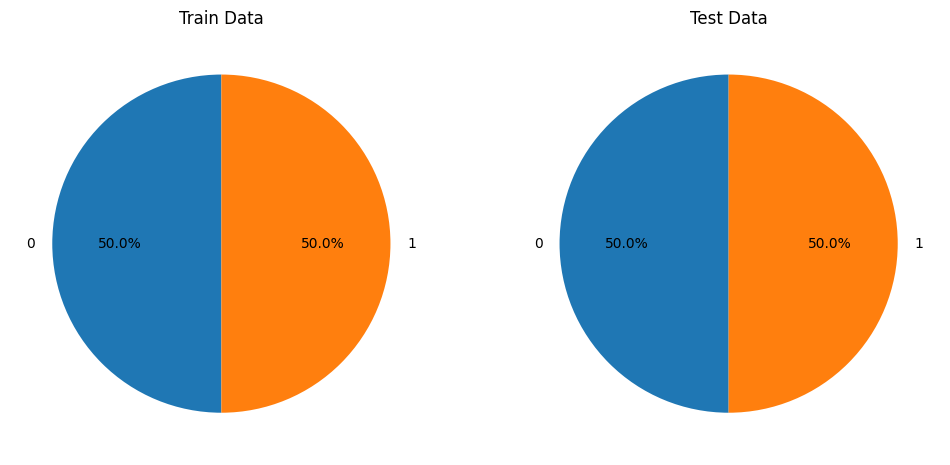

In [13]:
train_counts = train_df['label'].value_counts()
test_counts = test_df["label"].value_counts()
# Plot pie chart
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
train_counts.plot.pie(ax = axs[0], autopct='%1.1f%%', startangle=90)
test_counts.plot.pie(ax = axs[1], autopct='%1.1f%%', startangle=90)
axs[0].set_title('Train Data')
axs[0].set_ylabel('')
axs[1].set_title('Test Data')
axs[1].set_ylabel('')
plt.show()

Both the train and test dataset has exactly 50% positives and 50% negatives, in total we have 25,000 positve examples and 25% negative examples.

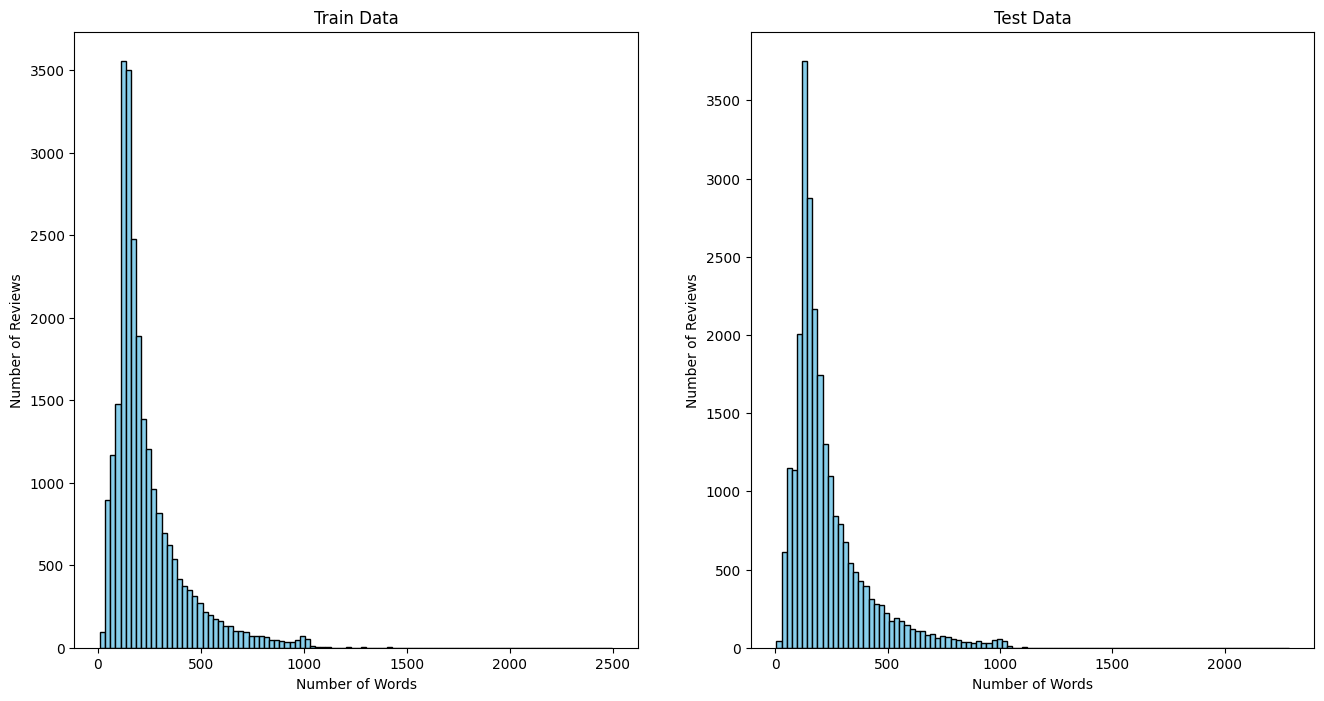

Train: 16.476 %
Test: 15.656 %


In [14]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(x.split()))

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].hist(train_df['word_count'], bins=100, color='skyblue', edgecolor='black')
axs[1].hist(test_df['word_count'], bins=100, color='skyblue', edgecolor='black')
axs[0].set_title('Train Data')
axs[0].set_ylabel('Number of Reviews')
axs[0].set_xlabel("Number of Words")
axs[1].set_title('Test Data')
axs[1].set_ylabel('Number of Reviews')
axs[1].set_xlabel("Number of Words")
plt.show()
train_count = (train_df["word_count"].to_numpy() >= 365).sum()   # 365 x 1.4 = 511
test_count = (test_df["word_count"].to_numpy() >= 365).sum()
print("Train:", train_count/25000 *100,"%")
print("Test:", test_count/25000 *100,"%")

I intended to use a BERT tokenizer to tokenize the text, while using a custom embedding layer instead of BERT's pretrained embeddings. The model is designed to accept a maximum of 512 time steps. Since the BERT tokenizer produces approximately 1.4 tokens per word on average, this corresponds to about $512 / 1.4 ≈ 365$ words. Around 15–16% of the dataset contains samples with at least 365 words, meaning these samples will be truncated to fit the input limit. For the majority of the dataset, however, the model will process the full input sequence without truncation.

## DataLoader

In [15]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.float32)
        }

## Model Definitions

### Configurable RNN Model

In [16]:
class AttentiveRNN(nn.Module):
    def __init__(self, hidden_dim, vocab_size, embed_dim, attention, bidirectional = False):
        super().__init__()
        self.hidden_dim = hidden_dim
        if bidirectional:
            self.output_dim = self.hidden_dim * 2
        else:
            self.output_dim = self.hidden_dim
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True, bidirectional = bidirectional)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.attention = attention
        self.output = nn.Linear(self.output_dim, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, attention_mask = None):                                                                      # x: (batch, seq_len)
        x = self.embedding(x)
        encoder_outputs, last_hidden_state = self.rnn(x)
        # encoder_outputs: (batch, seq_len, output_dim)
        # last_hidden_state: (directions, batch, hidden_dim)
        batch, seq_len, _ = encoder_outputs.shape
        if self.attention is not None:
            context, attn_weights = self.attention(encoder_outputs, last_hidden_state, attention_mask)
            # context: (batch, output_dim)
            # attn_weights: (batch, seq_len, 1)
            context = self.dropout(context)
        else:
            context = last_hidden_state.permute(1, 0, 2).contiguous()                     # (batch, directions, hidden_state_dim)
            context = context.view(context.size(0), -1)                                   # (batch, output_dim)
            attn_weights = torch.full((batch, seq_len, 1), 1.0 / seq_len, device=encoder_outputs.device, dtype=encoder_outputs.dtype)
            
        out = self.output(context)
        return out.squeeze(1), attn_weights.squeeze(2)

### Configurable LSTM Model

In [90]:
class AttentiveLSTM(nn.Module):
    def __init__(self, hidden_dim, vocab_size, embed_dim, attention, bidirectional = False):
        super().__init__()
        self.hidden_dim = hidden_dim
        if bidirectional:
            self.output_dim = self.hidden_dim * 2
        else:
            self.output_dim = self.hidden_dim
        self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional = bidirectional)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.attention = attention
        self.output = nn.Linear(self.output_dim, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, attention_mask):                                                                      # x: (batch, seq_len)
        x = self.embedding(x)
        encoder_outputs, (last_hidden_state, last_cell_state) = self.rnn(x)
        # encoder_outputs: (batch, seq_len, output_dim)
        # last_hidden_state: (directions, batch, hidden_dim)
        batch, seq_len, _ = encoder_outputs.shape
        if self.attention is not None:
            context, attn_weights = self.attention(encoder_outputs, last_hidden_state, attention_mask)
            # context: (batch, output_dim)
            # attn_weights: (batch, seq_len, 1)
            context = self.dropout(context)
        else:
            context = last_hidden_state.permute(1, 0, 2).contiguous()                     # (batch, directions, hidden_state_dim)
            context = context.view(context.size(0), -1)                                   # (batch, output_dim)
            attn_weights = torch.full((batch, seq_len, 1), 1.0 / seq_len, device=encoder_outputs.device, dtype=encoder_outputs.dtype)
            
        out = self.output(context)
        return out.squeeze(1), attn_weights.squeeze(2)

## Train, Dev, Test Split

Since both the original training and test sets contain 25,000 samples each, I first merge them into a single dataset of 50,000, and then split it into 40,000 for training, 5,000 for validation, and 5,000 for testing.

In [19]:
random_state = 42
tokenizer = BertTokenizer.from_pretrained(bert_model)
texts = train_df["text"].tolist() + test_df["text"].tolist()
labels = train_df["label"].tolist() + test_df["label"].tolist()

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=random_state, stratify = labels
)

dev_texts, test_texts, dev_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=random_state, stratify=temp_labels
)
print(f"Train Size: {len(train_texts)}")
print(f"Dev Size: {len(dev_texts)}")
print(f"Test Size: {len(test_texts)}")

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
dev_dataset   = SentimentDataset(dev_texts, dev_labels, tokenizer)
test_dataset  = SentimentDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
dev_loader   = DataLoader(dev_dataset, batch_size = batch_size)
test_loader  = DataLoader(test_dataset, batch_size = batch_size)

Train Size: 40000
Dev Size: 5000
Test Size: 5000


### Data Analysis on Train, Dev, Test Sets

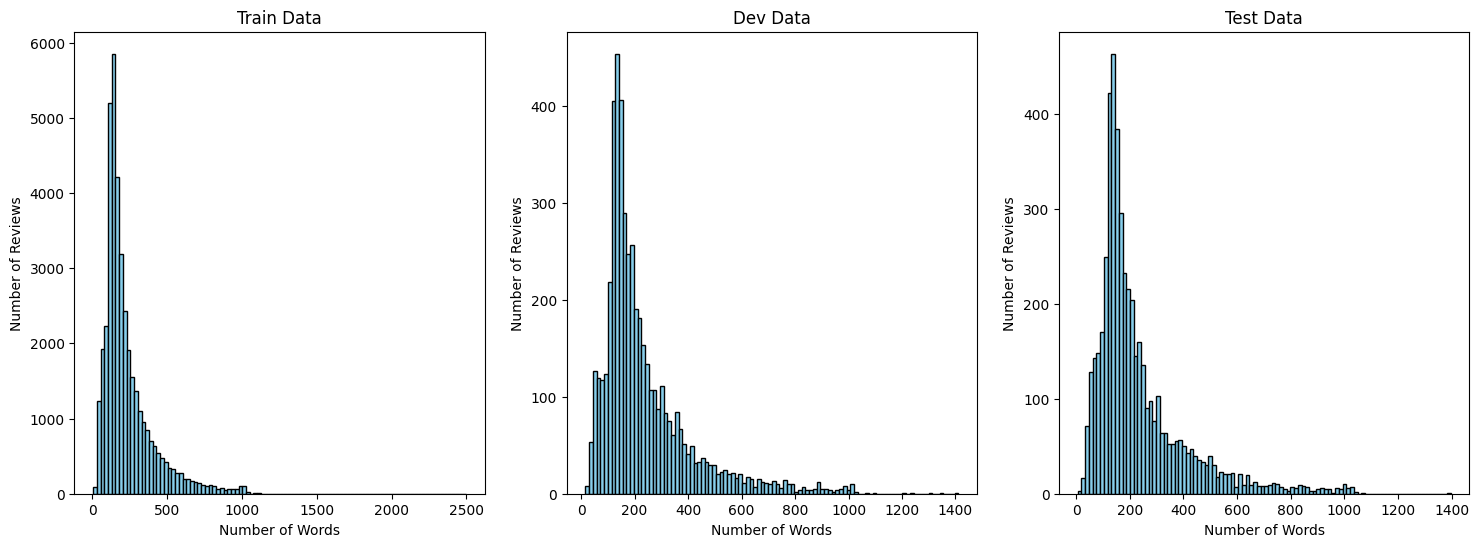

Train:  25.62%
Dev: 16.02%
Test: 16.52%


In [20]:
train_wc = np.array([len(text.split()) for text in train_texts])
dev_wc = np.array([len(text.split()) for text in dev_texts])
test_wc = np.array([len(text.split()) for text in test_texts])

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].hist(train_wc, bins=100, color='skyblue', edgecolor='black')
axs[1].hist(dev_wc, bins=100, color='skyblue', edgecolor='black')
axs[2].hist(test_wc, bins=100, color='skyblue', edgecolor='black')
axs[0].set_title('Train Data')
axs[0].set_ylabel('Number of Reviews')
axs[0].set_xlabel("Number of Words")
axs[1].set_title('Dev Data')
axs[1].set_ylabel('Number of Reviews')
axs[1].set_xlabel("Number of Words")
axs[2].set_title('Test Data')
axs[2].set_ylabel('Number of Reviews')
axs[2].set_xlabel("Number of Words")
plt.show()
train_count = (train_wc >= 365).sum()   # 365 x 1.4 = 511
dev_count = (dev_wc >= 365).sum()
test_count = (test_wc >= 365).sum()
print(f"Train: {train_count/25000 *100: .2f}%")
print(f"Dev: {dev_count/5000 *100:.2f}%")
print(f"Test: {test_count/5000 *100:.2f}%")

After splitting the data into training, dev, and test sets, about 25% of the training samples and 16% of the dev and test samples were cut off because they were too long.

## Training and Evaulating Functions

In [21]:
def train (model, device, criterion, optimizer, train_epochs = 10, pre_epochs =0):
    print(f"{'Progress':<14}{'Epoch':<10}{'Loss':<12}{'Accuracy':<16}{'training time per epoch'}")
    train_start = time.time()
    for epoch in range(train_epochs):
        start = time.time()
        model.train()
        total_loss = 0.0
        predicted = []
        target = []
    
        for i, batch in enumerate(train_loader):
            if i % 10 == 0:
                print(f"\r{(i+1)//10:<16}", end="")
    
            input_ids = batch["input_ids"].to(device)
            attention_masks = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
    
            # Forward pass
            optimizer.zero_grad()
            outputs, _ = model(input_ids, attention_masks)  # (batch,)
    
            # Compute loss and backprop
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
            # Convert predictions to binary
            preds = (outputs > 0.5).long().cpu().tolist()
            true = labels.long().cpu().tolist()
            predicted.extend(preds)
            target.extend(true)
    
        acc = accuracy_score(target, predicted)
        print(f"{pre_epochs + epoch + 1:<6}{total_loss:<14.4f}{acc * 100:.2f}%{time.time() - start:>20.2f} sec")
    seconds = time.time() - train_start
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    print("\n")
    print(f"Total Train Time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

In [22]:
def eval(model, device, loader):
    model.eval()

    predicted = []
    targets = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_masks = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs, _ = model(input_ids, attention_masks)     # [batch_size]
            outputs = torch.sigmoid(outputs)
            preds = (outputs > 0.5).long()                     # [batch_size] → binary preds

            predicted.extend(preds.tolist())                   # accumulate predictions
            targets.extend(labels.tolist())

    # Evaluation
    accuracy = accuracy_score(predicted, targets)
    
    # Macro metrics
    precision_macro = precision_score(predicted, targets, average='macro')
    recall_macro = recall_score(predicted, targets, average='macro')
    f1_macro = f1_score(predicted, targets, average='macro')
    
    # Micro metrics
    precision_micro = precision_score(predicted, targets, average='micro')
    recall_micro = recall_score(predicted, targets, average='micro')
    f1_micro = f1_score(predicted, targets, average='micro')
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(predicted, targets)
    
    # HTML Table
    html_table = f"""
    <table style="width:50%; border-collapse: collapse; font-size: 16px;">
        <thead>
            <tr>
                <th style="border: 1px solid #ddd; padding: 8px;">Metric</th>
                <th style="border: 1px solid #ddd; padding: 8px;">Macro</th>
                <th style="border: 1px solid #ddd; padding: 8px;">Micro</th>
            </tr>
        </thead>
        <tbody>
            <tr><td style="border: 1px solid #ddd; padding: 8px;">Accuracy</td>
                <td colspan="2" style="border: 1px solid #ddd; padding: 12px; text-align: center;">
                    <b style="font-size: 18px;">{accuracy*100:.2f}%</b>
                </td>
            </tr>
    
            <tr><td style="border: 1px solid #ddd; padding: 8px;">Precision</td>
                <td style="border: 1px solid #ddd; padding: 8px;">{precision_macro*100:.2f}%</td>
                <td style="border: 1px solid #ddd; padding: 8px;">{precision_micro*100:.2f}%</td></tr>
    
            <tr><td style="border: 1px solid #ddd; padding: 8px;">Recall</td>
                <td style="border: 1px solid #ddd; padding: 8px;">{recall_macro*100:.2f}%</td>
                <td style="border: 1px solid #ddd; padding: 8px;">{recall_micro*100:.2f}%</td></tr>
    
            <tr><td style="border: 1px solid #ddd; padding: 8px;">F1 Score</td>
                <td style="border: 1px solid #ddd; padding: 8px;">{f1_macro*100:.2f}%</td>
                <td style="border: 1px solid #ddd; padding: 8px;">{f1_micro*100:.2f}%</td></tr>
        </tbody>
    </table>
    """

    
    display(HTML(html_table))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Negative', 'Positive'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

In [23]:
def save_model_as_zip(model, model_name, save_dir="/kaggle/working"):
    # File paths
    model_path = os.path.join(save_dir, f"{model_name}.pth")
    zip_path = os.path.join(save_dir, f"{model_name}.zip")

    # Save model
    torch.save(model.state_dict(), model_path)

    # Zip it
    with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(model_path, arcname=f"{model_name}.pth")

    # Remove unzipped .pth file
    os.remove(model_path)

    # Get zipped size in MB
    size_bytes = os.path.getsize(zip_path)
    size_mb = size_bytes / (1024 ** 2)

    print(f"{model_name}.zip saved at {zip_path} | Size: {size_mb:.2f} MB")

# Loss Function and Optmizer

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()

# RNN Models

## Vanilla RNN

In [52]:
rnn_model_0 = AttentiveRNN(256, tokenizer.vocab_size, 512, attention = None, bidirectional = False).to(device)
optimizer_0 = torch.optim.Adam(rnn_model_0.parameters(), lr=2e-4)

In [55]:
if not load_pre_trained_model:
    train(rnn_model_0, device, criterion, optimizer_0, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "rnn_model_0.pth")
    rnn_model_0.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     434.2820      50.19%               86.13 sec
62              2     433.2283      50.57%               86.71 sec
62              3     431.5752      51.31%               86.16 sec
62              4     429.7604      51.89%               85.03 sec
62              5     428.6606      51.90%               84.98 sec
62              6     430.1749      51.73%               84.04 sec
62              7     427.0089      52.23%               85.03 sec
62              8     423.6775      52.70%               85.83 sec
62              9     423.2495      52.83%               85.06 sec
62              10    421.4855      52.95%               87.62 sec
62              11    418.0811      53.28%               85.97 sec
62              12    413.9185      53.74%               85.33 sec
62              13    409.3127      54.23%               85.62 sec
62              14    420.8127      53.20%           

* Total Train Time: 0h 28m 28s
* Train Time Per Epoch: 85s ~ 86s
* Training Accuracy: 53.71%
* Batch size: 64

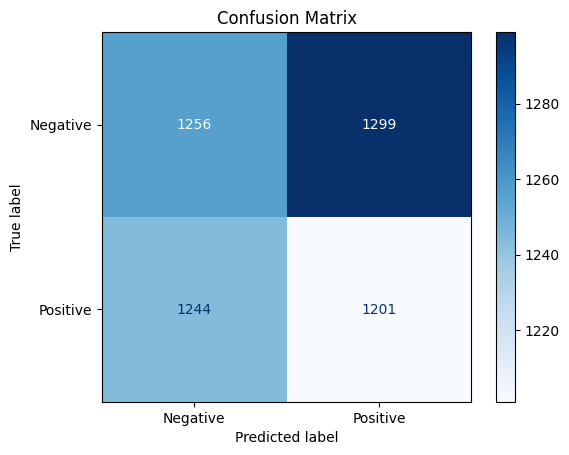

In [58]:
eval(rnn_model_0, device, dev_loader)

In [59]:
if save_model:
    save_model_as_zip(rnn_model_0, "rnn_model_0")

rnn_model_0.zip saved at /kaggle/working/rnn_model_0.zip | Size: 55.91 MB


## RNN with "dot" Multiplicative Attention

In [60]:
attention_1 = MultiplicativeAttentions(256, scoring_function = "dot").to(device)
rnn_model_1 = AttentiveRNN(256, tokenizer.vocab_size, 512, attention = attention_1, bidirectional = False).to(device)
optimizer_1 = torch.optim.Adam(rnn_model_1.parameters(), lr=1e-4)

In [61]:
if not load_pre_trained_model:
    train(rnn_model_1, device, criterion, optimizer_1, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "rnn_model_1.pth")
    rnn_model_1.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     375.7852      62.32%               87.65 sec
62              2     304.5618      74.48%               86.75 sec
62              3     270.8043      78.11%               85.22 sec
62              4     245.2738      80.84%               86.72 sec
62              5     226.4507      82.55%               87.79 sec
62              6     210.6167      84.08%               84.89 sec
62              7     196.0480      85.44%               85.62 sec
62              8     181.9640      86.68%               84.93 sec
62              9     168.3646      88.01%               84.20 sec
62              10    152.8050      89.33%               84.55 sec
62              11    138.4463      90.34%               85.03 sec
62              12    124.9529      91.50%               84.38 sec
62              13    112.8745      92.34%               84.95 sec
62              14    100.5378      93.55%           

* Total Train Time: 0h 28m 24s
* Train Time Per Epoch: 84s ~ 87s
* Training Accracy: 96.84%
* Batch Size: 64

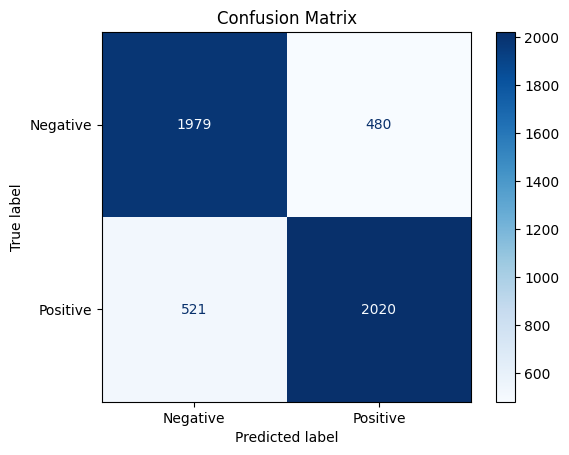

In [62]:
eval(rnn_model_1, device, dev_loader)

I have also trained with 128 hidden dimensions too and the results are

**Model Config**: input_dim=512, hidden_dim=128, batch_size=512

**Train Acc**: 87.57%

**Test Metrics**: 
**Accuracy**: 73.95% 
**Precision**: 73.95% 
**Recall**: 73.99% 
**F1**: 73.94%

**Confusion Matrix**:
```bash
[[4499 1505]
 [1751 4745]]
```

In [63]:
if save_model:
    save_model_as_zip(rnn_model_1, "rnn_model_1")

rnn_model_1.zip saved at /kaggle/working/rnn_model_1.zip | Size: 56.60 MB


## RNN with "general" Multiplicative Attention

In [25]:
attention_2 = MultiplicativeAttentions(256, scoring_function = "general").to(device)
rnn_model_2 = AttentiveRNN(256, tokenizer.vocab_size, 512, attention = attention_2, bidirectional = False).to(device)
optimizer_2 = torch.optim.Adam(rnn_model_2.parameters(), lr=1e-4)

In [28]:
if not load_pre_trained_model:
    train(rnn_model_2, device, criterion, optimizer_2, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "rnn_model_2.pth")
    rnn_model_2.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     347.7177      67.73%              137.19 sec
62              2     293.8232      76.02%              131.81 sec
62              3     264.2075      79.61%              130.70 sec
62              4     238.0278      81.97%               93.96 sec
62              5     217.4647      84.26%               85.43 sec
62              6     207.3202      85.25%               84.40 sec
62              7     238.4441      83.28%               85.34 sec
62              8     178.2110      87.73%               85.36 sec
62              9     164.1993      88.92%               84.89 sec
62              10    156.7881      89.68%               85.36 sec
62              11    146.6483      90.44%               85.36 sec
62              12    169.7652      88.44%               84.49 sec
62              13    135.8995      91.20%               85.26 sec
62              14    117.5262      92.54%           

* Total Train Time: 0h 30m 54s
* Train Time Per Epoch: 84s ~ 137s
* Training Accracy: 95.67%
* Batch Size: 64

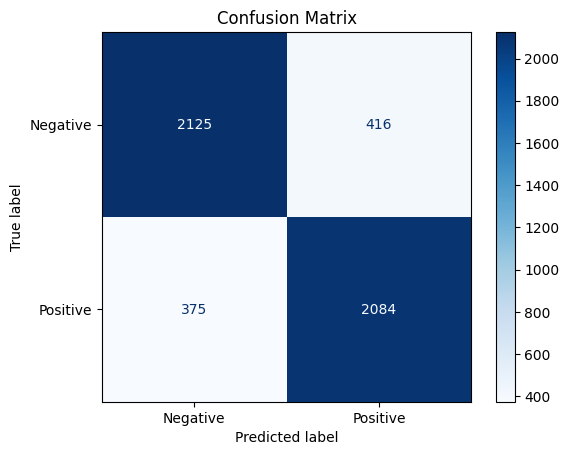

In [31]:
eval(rnn_model_2, device, dev_loader)

In [32]:
if save_model:
    save_model_as_zip(rnn_model_2, "rnn_model_2")

rnn_model_2.zip saved at /kaggle/working/rnn_model_2.zip | Size: 56.60 MB


## RNN with "concat" Multiplicative Attention

In [33]:
attention_3 = MultiplicativeAttentions(256, scoring_function = "general").to(device)
rnn_model_3 = AttentiveRNN(256, tokenizer.vocab_size, 512, attention = attention_3, bidirectional = False).to(device)
optimizer_3 = torch.optim.Adam(rnn_model_3.parameters(), lr=1e-4)

In [34]:
if not load_pre_trained_model:
    train(rnn_model_3, device, criterion, optimizer_3, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "rnn_model_3.pth")
    rnn_model_3.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     367.6249      62.92%               84.91 sec
62              2     285.5861      76.71%               84.68 sec
62              3     255.1178      80.36%               85.39 sec
62              4     229.4402      83.06%               85.24 sec
62              5     207.0956      85.05%               84.62 sec
62              6     186.1886      87.02%               85.40 sec
62              7     167.4645      88.63%               84.84 sec
62              8     146.8988      90.25%               84.89 sec
62              9     131.5358      91.32%               85.21 sec
62              10    115.5124      92.66%               85.55 sec
62              11    104.4474      93.37%               84.76 sec
62              12    91.3033       94.43%               84.78 sec
62              13    77.3875       95.24%               84.57 sec
62              14    64.4010       96.23%           

* Total Train Time: 0h 28m 18s
* Train Time Per Epoch: 84s ~ 85s
* Training Accracy: 97.94%
* Batch Size: 64

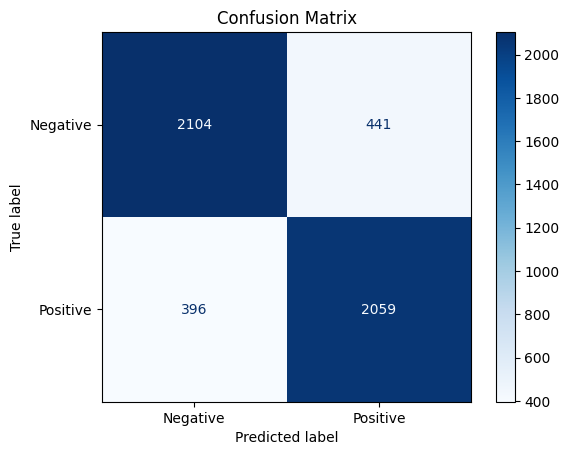

In [43]:
eval(rnn_model_3, device, dev_loader)

In [44]:
if save_model:
    save_model_as_zip(rnn_model_3, "rnn_model_3")

rnn_model_3.zip saved at /kaggle/working/rnn_model_3.zip | Size: 56.60 MB


# Bidirectional RNN Models

## Vanilla Bi-RNN

In [45]:
rnn_model_4 = AttentiveRNN(256, tokenizer.vocab_size, 512, attention = None, bidirectional = True).to(device)
optimizer_4 = torch.optim.Adam(rnn_model_4.parameters(), lr=1e-4)

In [46]:
if not load_pre_trained_model:
    train(rnn_model_4, device, criterion, optimizer_4, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "rnn_model_4.pth")
    rnn_model_4.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     426.1195      52.02%               84.97 sec
62              2     398.9407      60.17%               85.04 sec
62              3     393.3124      61.10%               85.86 sec
62              4     419.9687      52.21%               85.62 sec
62              5     398.8455      59.63%               85.01 sec
62              6     384.4077      61.40%               85.09 sec
62              7     365.2749      65.61%               84.85 sec
62              8     373.6912      63.08%               84.69 sec
62              9     346.7102      68.94%               85.19 sec
62              10    356.7653      65.70%               85.77 sec
62              11    334.0787      70.41%               85.03 sec
62              12    327.2674      72.08%               85.38 sec
62              13    324.6212      72.07%               84.77 sec
62              14    309.5489      74.56%           

* Total Train Time: 0h 28m 21s
* Train Time Per Epoch: 84s ~ 85s
* Training Accracy: 81.92%
* Batch Size: 64

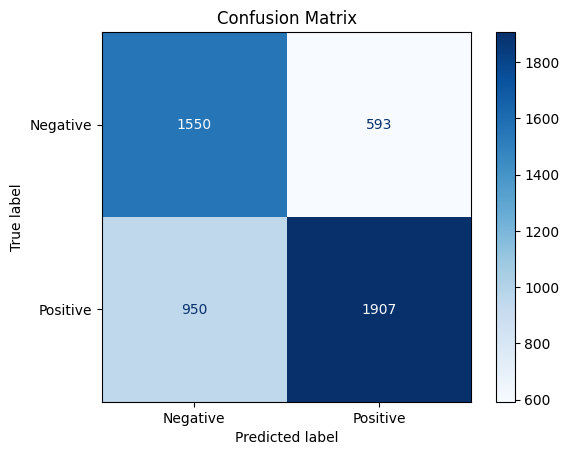

In [54]:
eval(rnn_model_4, device, dev_loader)

In [55]:
if save_model:
    save_model_as_zip(rnn_model_4, "rnn_model_4")

rnn_model_4.zip saved at /kaggle/working/rnn_model_4.zip | Size: 56.60 MB


## Bi-RNN with "dot" Attention

In [61]:
attention_5 = MultiplicativeAttentions(256, scoring_function = "dot", bidirectional = True).to(device)
rnn_model_5 = AttentiveRNN(256, tokenizer.vocab_size, 512, attention = attention_5, bidirectional = True).to(device)
optimizer_5 = torch.optim.Adam(rnn_model_5.parameters(), lr=5e-5)

In [62]:
if not load_pre_trained_model:
    train(rnn_model_5, device, criterion, optimizer_5, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "rnn_model_5.pth")
    rnn_model_5.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     434.2131      50.41%               87.32 sec
62              2     422.0176      53.52%               86.37 sec
62              3     397.1805      60.16%               88.79 sec
62              4     360.4677      69.38%               87.15 sec
62              5     356.1459      69.83%               86.70 sec
62              6     373.9736      65.25%               86.83 sec
62              7     367.0427      66.86%               88.18 sec
62              8     333.6955      73.89%               87.29 sec
62              9     366.0292      66.92%               86.92 sec
62              10    398.7308      59.27%               87.40 sec
62              11    332.6679      73.69%               88.29 sec
62              12    310.2887      76.53%               86.28 sec
62              13    307.4305      76.10%               86.54 sec
62              14    291.8896      78.68%           

* Total Train Time: 0h 29m 3s
* Train Time Per Epoch: 86s ~ 88s
* Training Accracy: 81.80%
* Batch Size: 64

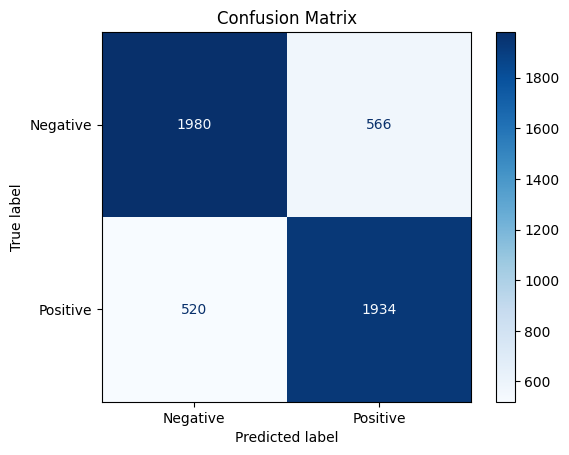

In [67]:
eval(rnn_model_5, device, dev_loader)

In [68]:
if save_model:
    save_model_as_zip(rnn_model_5, "rnn_model_5")

rnn_model_5.zip saved at /kaggle/working/rnn_model_5.zip | Size: 58.44 MB


## Bi-RNN with "general" Attention

In [69]:
attention_6 = MultiplicativeAttentions(256, scoring_function = "general", bidirectional = True).to(device)
rnn_model_6 = AttentiveRNN(256, tokenizer.vocab_size, 512, attention = attention_6, bidirectional = True).to(device)
optimizer_6 = torch.optim.Adam(rnn_model_6.parameters(), lr=1e-4)

In [70]:
if not load_pre_trained_model:
    train(rnn_model_6, device, criterion, optimizer_6, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "rnn_model_6.pth")
    rnn_model_6.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     387.6773      59.23%               88.64 sec
62              2     359.3903      66.96%               89.46 sec
62              3     352.4644      68.20%               91.41 sec
62              4     343.5465      70.00%               91.41 sec
62              5     326.9246      72.72%               90.28 sec
62              6     323.1908      72.82%               89.40 sec
62              7     313.1999      74.24%               90.96 sec
62              8     301.2497      75.85%               91.15 sec
62              9     295.3044      76.77%               90.01 sec
62              10    290.4290      77.13%               90.51 sec
62              11    282.9761      78.10%               89.62 sec
62              12    303.5461      75.33%               91.51 sec
62              13    292.7464      76.94%               90.01 sec
62              14    279.9661      78.67%           

* Total Train Time: 0h 30m 8s
* Train Time Per Epoch: 88s ~ 91s
* Training Accracy: 80.47%
* Batch Size: 64

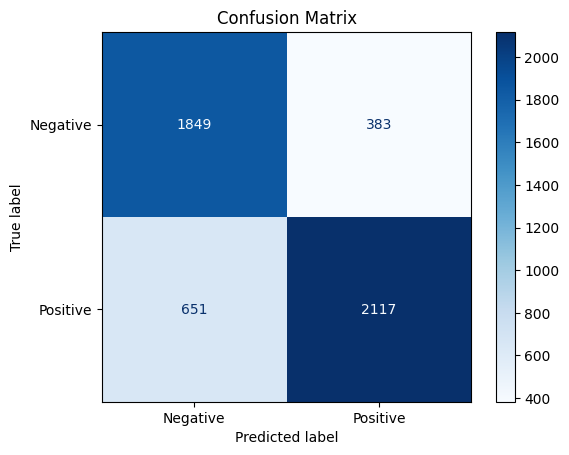

In [78]:
eval(rnn_model_6, device, dev_loader)

In [79]:
if save_model:
    save_model_as_zip(rnn_model_6, "rnn_model_6")

rnn_model_6.zip saved at /kaggle/working/rnn_model_6.zip | Size: 58.44 MB


## Bi-RNN with "concat" Attention

In [80]:
attention_7 = MultiplicativeAttentions(256, scoring_function = "concat", bidirectional = True).to(device)
rnn_model_7 = AttentiveRNN(256, tokenizer.vocab_size, 512, attention = attention_7, bidirectional = True).to(device)
optimizer_7 = torch.optim.Adam(rnn_model_7.parameters(), lr=1e-4)

In [81]:
if not load_pre_trained_model:
    train(rnn_model_7, device, criterion, optimizer_7, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "rnn_model_7.pth")
    rnn_model_7.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     306.5192      72.73%               92.81 sec
62              2     201.1816      85.59%               91.82 sec
62              3     165.3095      88.55%               92.14 sec
62              4     139.1737      90.75%               93.02 sec
62              5     119.0747      92.34%               90.84 sec
62              6     101.4374      93.58%               92.01 sec
62              7     83.0823       94.98%               91.86 sec
62              8     68.2345       95.97%               91.54 sec
62              9     53.2723       97.04%               89.58 sec
62              10    40.9307       97.79%               91.86 sec
62              11    30.4454       98.42%               92.22 sec
62              12    23.6612       98.76%               91.80 sec
62              13    17.6268       99.11%               91.19 sec
62              14    15.8208       99.16%           

* Total Train Time: 0h 30m 30s
* Train Time Per Epoch: 90s ~ 92s
* Training Accracy: 99.56%
* Batch Size: 64

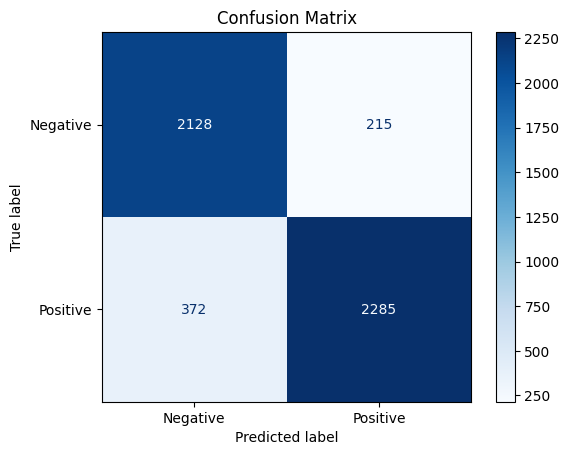

In [83]:
eval(rnn_model_7, device, dev_loader)

In [84]:
if save_model:
    save_model_as_zip(rnn_model_7, "rnn_model_7")

rnn_model_7.zip saved at /kaggle/working/rnn_model_7.zip | Size: 58.46 MB


# LSTM Models

## Vanilla LSTM

In [91]:
lstm_model_0 = AttentiveLSTM(256, tokenizer.vocab_size, 512, attention = None, bidirectional = False).to(device)
optimizer_8 = torch.optim.Adam(lstm_model_0.parameters(), lr=1e-4)

In [92]:
if not load_pre_trained_model:
    train(lstm_model_0, device, criterion, optimizer_8, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "lstm_model_0.pth")
    lstm_model_0.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     433.1084      50.04%               89.73 sec
62              2     431.2606      50.65%               89.56 sec
62              3     426.6933      52.02%               89.02 sec
62              4     418.6664      53.67%               90.26 sec
62              5     402.3697      53.87%               89.60 sec
62              6     398.9692      54.24%               90.52 sec
62              7     386.5945      54.71%               90.07 sec
62              8     377.7529      56.29%               90.66 sec
62              9     380.3649      57.48%               88.43 sec
62              10    368.8948      60.88%               87.98 sec
62              11    367.2994      61.74%               87.70 sec
62              12    366.6709      63.39%               88.14 sec
62              13    363.1590      66.42%               87.94 sec
62              14    365.1417      67.71%           

* Total Train Time: 0h 29m 33s
* Train Time Per Epoch: 86s ~ 90s
* Training Accracy: 61.63%
* Batch Size: 64

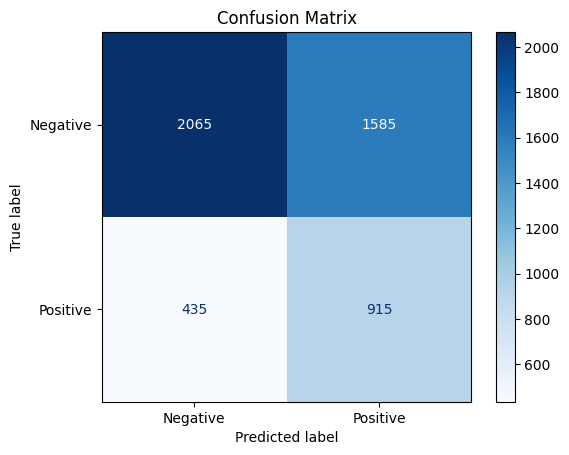

In [94]:
eval(lstm_model_0, device, dev_loader)

In [95]:
if save_model:
    save_model_as_zip(lstm_model_0, "lstm_model_0")

lstm_model_0.zip saved at /kaggle/working/lstm_model_0.zip | Size: 57.99 MB


## LSTM with "dot" Attention

In [96]:
attention_1 = MultiplicativeAttentions(256, scoring_function = "dot", bidirectional = False).to(device)
lstm_model_1 = AttentiveLSTM(256, tokenizer.vocab_size, 512, attention = attention_1, bidirectional = False).to(device)
optimizer_9 = torch.optim.Adam(lstm_model_1.parameters(), lr=1e-4)

In [97]:
if not load_pre_trained_model:
    train(lstm_model_1, device, criterion, optimizer_9, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "lstm_model_1.pth")
    lstm_model_1.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     351.7954      65.92%               88.90 sec
62              2     230.9895      83.56%               92.14 sec
62              3     201.4384      86.39%               91.67 sec
62              4     371.9987      71.82%               90.64 sec
62              5     277.2069      79.23%               89.88 sec
62              6     191.1176      87.45%               89.49 sec
62              7     159.4489      90.07%               89.21 sec
62              8     137.8632      91.65%               89.47 sec
62              9     111.8464      93.70%               89.51 sec
62              10    104.4534      94.31%               90.10 sec
62              11    87.4881       95.49%               89.06 sec
62              12    68.7613       96.74%               89.55 sec
62              13    59.4375       97.27%               89.43 sec
62              14    47.9336       98.06%           

* Total Train Time: 0h 29m 56s
* Train Time Per Epoch: 88s ~ 92s
* Training Accracy: 96.01%
* Batch Size: 64

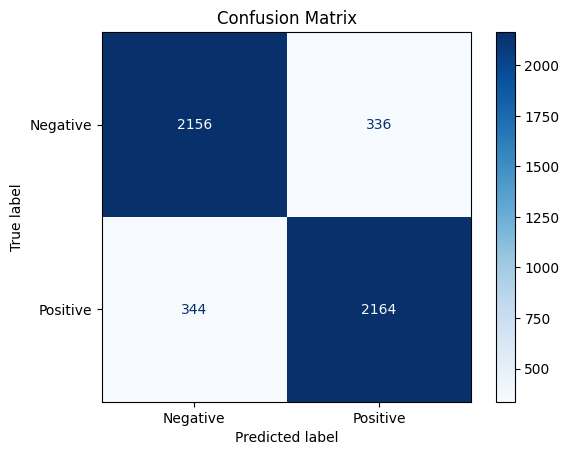

In [98]:
eval(lstm_model_1, device, dev_loader)

In [99]:
if save_model:
    save_model_as_zip(lstm_model_1, "lstm_model_1")

lstm_model_1.zip saved at /kaggle/working/lstm_model_1.zip | Size: 58.69 MB


## LSTM with "general" Attention

In [100]:
attention_2 = MultiplicativeAttentions(256, scoring_function = "general", bidirectional = False).to(device)
lstm_model_2 = AttentiveLSTM(256, tokenizer.vocab_size, 512, attention = attention_2, bidirectional = False).to(device)
optimizer_10 = torch.optim.Adam(lstm_model_2.parameters(), lr=1e-4)

In [101]:
if not load_pre_trained_model:
    train(lstm_model_2, device, criterion, optimizer_10, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "lstm_model_2.pth")
    lstm_model_2.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     322.1351      70.28%               89.90 sec
62              2     205.4953      85.67%               90.61 sec
62              3     164.6527      89.04%               90.85 sec
62              4     138.0824      91.27%               91.86 sec
62              5     117.3769      92.84%               89.93 sec
62              6     96.6198       94.29%               90.03 sec
62              7     81.9575       95.24%               89.78 sec
62              8     67.4564       96.20%               89.79 sec
62              9     57.9481       96.90%               89.84 sec
62              10    126.3379      92.48%               90.46 sec
62              11    58.9945       96.78%               90.77 sec
62              12    40.4858       97.97%               89.03 sec
62              13    34.2602       98.35%               89.49 sec
62              14    31.4951       98.49%           

* Total Train Time: 0h 29m 59s
* Train Time Per Epoch: 89s ~ 91s
* Training Accracy: 97.52%
* Batch Size: 64

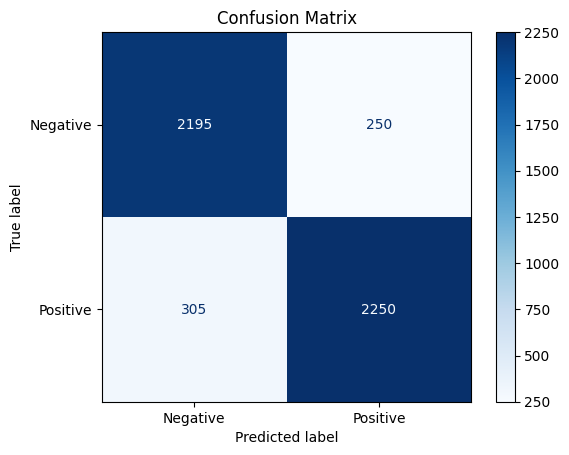

In [103]:
eval(lstm_model_2, device, dev_loader)

In [104]:
if save_model:
    save_model_as_zip(lstm_model_2, "lstm_model_2")

lstm_model_2.zip saved at /kaggle/working/lstm_model_2.zip | Size: 58.69 MB


## LSTM with "concat" Attention

In [105]:
attention_3 = MultiplicativeAttentions(256, scoring_function = "concat", bidirectional = False).to(device)
lstm_model_3 = AttentiveLSTM(256, tokenizer.vocab_size, 512, attention = attention_3, bidirectional = False).to(device)
optimizer_11 = torch.optim.Adam(lstm_model_3.parameters(), lr=1e-4)

In [106]:
if not load_pre_trained_model:
    train(lstm_model_3, device, criterion, optimizer_11, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "lstm_model_3.pth")
    lstm_model_3.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     309.9078      71.77%               90.33 sec
62              2     198.1418      86.09%               91.24 sec
62              3     177.0915      88.58%               91.41 sec
62              4     139.9905      90.94%               90.85 sec
62              5     120.8618      92.42%               91.60 sec
62              6     100.0169      93.89%               90.02 sec
62              7     84.7384       95.12%               91.02 sec
62              8     71.4714       95.96%               90.52 sec
62              9     57.2487       96.93%               90.77 sec
62              10    47.5344       97.48%               90.89 sec
62              11    37.4827       98.15%               90.36 sec
62              12    34.1586       98.28%               89.99 sec
62              13    26.4568       98.77%               90.53 sec
62              14    24.5948       98.83%           

* Total Train Time: 0h 30m 07s
* Train Time Per Epoch: 88s ~ 91s
* Training Accracy: 99.38%
* Batch Size: 64

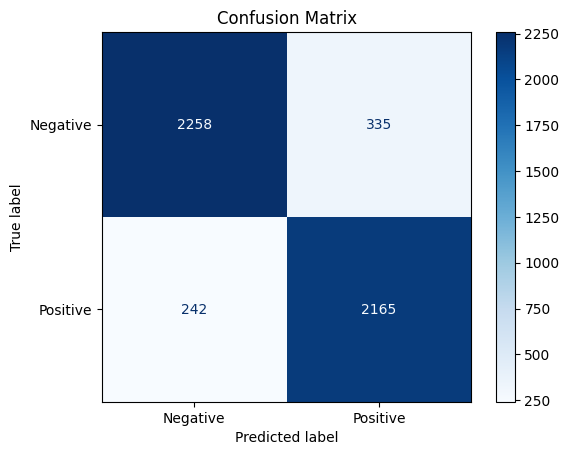

In [107]:
eval(lstm_model_3, device, dev_loader)

In [108]:
if save_model:
    save_model_as_zip(lstm_model_3, "lstm_model_3")

lstm_model_3.zip saved at /kaggle/working/lstm_model_3.zip | Size: 58.69 MB


# Bidirectional LSTM Models

In [109]:
lstm_model_4 = AttentiveLSTM(256, tokenizer.vocab_size, 512, attention = None, bidirectional = True).to(device)
optimizer_12 = torch.optim.Adam(lstm_model_4.parameters(), lr=1e-4)

In [110]:
if not load_pre_trained_model:
    train(lstm_model_4, device, criterion, optimizer_12, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "lstm_model_4.pth")
    lstm_model_4.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     402.0263      58.23%              100.11 sec
62              2     351.6844      68.86%               99.91 sec
62              3     292.0289      77.90%              100.89 sec
62              4     245.7825      83.02%              100.82 sec
62              5     215.4065      85.40%              100.86 sec
62              6     173.0406      89.06%              100.81 sec
62              7     154.3246      90.21%              101.12 sec
62              8     126.0459      92.49%              101.71 sec
62              9     112.7600      93.36%              101.06 sec
62              10    100.7112      94.12%              106.05 sec
62              11    184.0329      86.69%              109.92 sec
62              12    88.6805       94.97%              104.73 sec
62              13    70.8968       96.20%              105.94 sec
62              14    60.1548       96.84%           

* Total Train Time: 0h 34m 23s
* Train Time Per Epoch: 99s ~ 109s
* Training Accracy: 98.28%
* Batch Size: 64

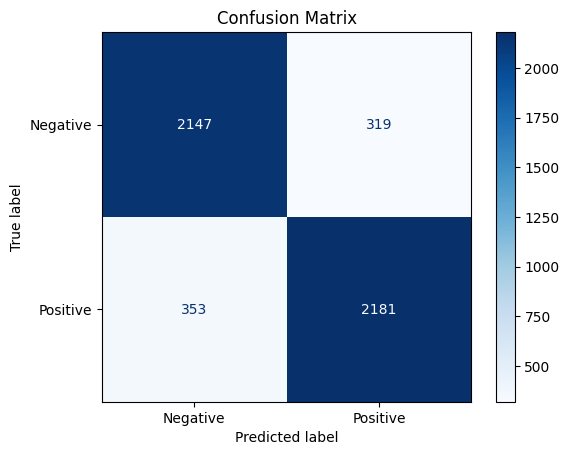

In [112]:
eval(lstm_model_4, device, dev_loader)

In [113]:
if save_model:
    save_model_as_zip(lstm_model_4, "lstm_model_4")

lstm_model_4.zip saved at /kaggle/working/lstm_model_4.zip | Size: 60.78 MB


## Bi-LSTM with "dot" Attention

In [114]:
attention_4 = MultiplicativeAttentions(256, scoring_function = "dot", bidirectional = True).to(device)
lstm_model_5 = AttentiveLSTM(256, tokenizer.vocab_size, 512, attention = attention_4, bidirectional = True).to(device)
optimizer_13 = torch.optim.Adam(lstm_model_5.parameters(), lr=1e-4)

In [115]:
if not load_pre_trained_model:
    train(lstm_model_5, device, criterion, optimizer_13, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "lstm_model_5.pth")
    lstm_model_5.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     363.4089      64.52%              105.87 sec
62              2     231.8947      83.07%              106.23 sec
62              3     167.6301      88.81%              104.64 sec
62              4     129.0442      91.83%              105.21 sec
62              5     98.5995       93.97%              105.70 sec
62              6     74.1124       95.74%              105.42 sec
62              7     52.5752       97.15%              104.56 sec
62              8     38.4538       98.06%              104.78 sec
62              9     28.7152       98.59%              105.82 sec
62              10    23.5255       98.87%              104.68 sec
62              11    20.8855       99.04%              105.55 sec
62              12    16.0599       99.28%              105.26 sec
62              13    15.3435       99.28%              105.56 sec
62              14    12.7254       99.44%           

* Total Train Time: 0h 35m 3s
* Train Time Per Epoch: 104s ~ 106s
* Training Accracy: 99.74%
* Batch Size: 64

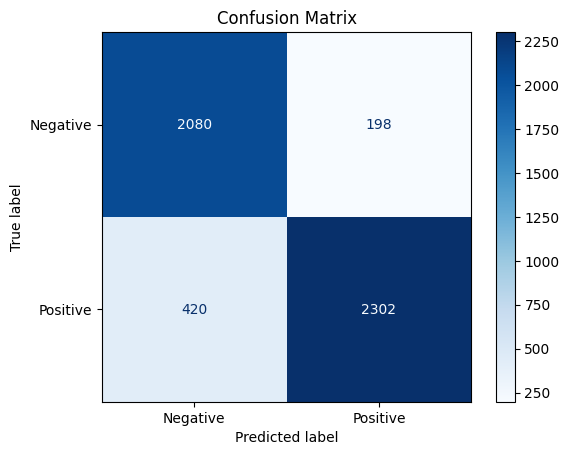

In [117]:
eval(lstm_model_5, device, dev_loader)

In [118]:
if save_model:
    save_model_as_zip(lstm_model_5, "lstm_model_5")

lstm_model_5.zip saved at /kaggle/working/lstm_model_5.zip | Size: 62.61 MB


## Bi-LSTM with "general" Attention

In [119]:
attention_5 = MultiplicativeAttentions(256, scoring_function = "general", bidirectional = True).to(device)
lstm_model_6 = AttentiveLSTM(256, tokenizer.vocab_size, 512, attention = attention_5, bidirectional = True).to(device)
optimizer_14 = torch.optim.Adam(lstm_model_6.parameters(), lr=1e-4)

In [120]:
if not load_pre_trained_model:
    train(lstm_model_6, device, criterion, optimizer_14, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "lstm_model_6.pth")
    lstm_model_6.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     351.1434      67.16%              110.55 sec
62              2     225.7854      83.59%              110.40 sec
62              3     163.1498      89.18%              110.17 sec
62              4     122.4316      92.35%              109.83 sec
62              5     91.6585       94.56%              110.57 sec
62              6     67.5057       96.13%              112.90 sec
62              7     48.3958       97.36%              115.68 sec
62              8     39.0752       98.00%              112.13 sec
62              9     30.1469       98.56%              113.05 sec
62              10    25.6607       98.78%              116.57 sec
62              11    21.7075       98.98%              117.76 sec
62              12    20.7019       99.02%              114.73 sec
62              13    16.9468       99.21%              113.84 sec
62              14    16.6615       99.22%           

* Total Train Time: 0h 37m 50s
* Train Time Per Epoch: 109s ~ 117s
* Training Accracy: 99.47%
* Batch Size: 64

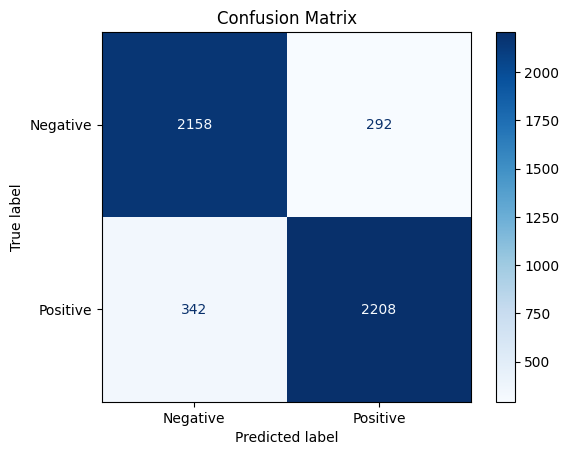

In [122]:
eval(lstm_model_6, device, dev_loader)

In [123]:
if save_model:
    save_model_as_zip(lstm_model_6, "lstm_model_6")

lstm_model_6.zip saved at /kaggle/working/lstm_model_6.zip | Size: 62.61 MB


## Bi-LSTM with "concat" Attention

In [126]:
attention_6 = MultiplicativeAttentions(256, scoring_function = "concat", bidirectional = True).to(device)
lstm_model_7 = AttentiveLSTM(256, tokenizer.vocab_size, 512, attention = attention_6, bidirectional = True).to(device)
optimizer_15 = torch.optim.Adam(lstm_model_7.parameters(), lr=1e-4)

In [127]:
if not load_pre_trained_model:
    train(lstm_model_7, device, criterion, optimizer_15, train_epochs =20, pre_epochs = 0)
else:
    saved_path = os.path.join(saved_dir, "lstm_model_7.pth")
    lstm_model_7.load_state_dict(torch.load(saved_path))

Progress      Epoch     Loss        Accuracy        training time per epoch
62              1     299.0117      72.88%              117.94 sec
62              2     187.6341      86.78%              115.07 sec
62              3     150.8223      89.94%              118.51 sec
62              4     120.9965      92.14%              116.97 sec
62              5     96.4091       93.96%              114.97 sec
62              6     79.1075       95.12%              115.65 sec
62              7     58.3872       96.50%              114.60 sec
62              8     42.8601       97.71%              114.32 sec
62              9     33.9431       98.22%              115.14 sec
62              10    31.2502       98.30%              116.56 sec
62              11    21.6464       98.95%              116.11 sec
62              12    17.3446       99.15%              116.72 sec
62              13    15.0190       99.36%              117.11 sec
62              14    12.3340       99.39%           

* Total Train Time: 0h 38m 47s
* Train Time Per Epoch: 1114s ~ 118s
* Training Accracy: 99.62%
* Batch Size: 64

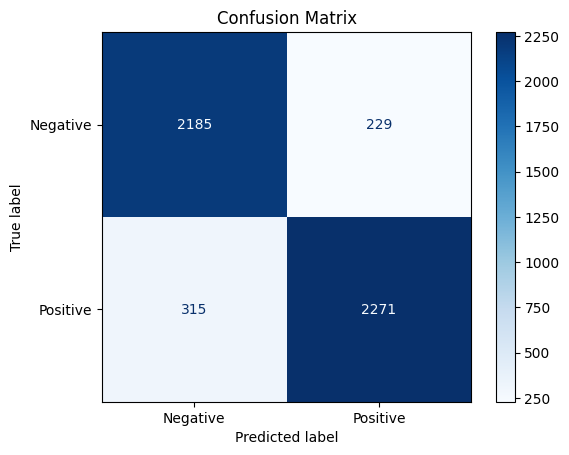

In [129]:
eval(lstm_model_7, device, dev_loader)

In [130]:
if save_model:
    save_model_as_zip(lstm_model_7, "lstm_model_7")

lstm_model_7.zip saved at /kaggle/working/lstm_model_7.zip | Size: 62.63 MB
